In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import mlxtend

for i in [pd, np, sklearn, scipy, mlxtend]:
    print(i.__name__, i.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

pandas 1.3.5
numpy 1.22.0
sklearn 1.1.1
scipy 1.8.1
mlxtend 0.21.0


In [50]:
# 시각화 모듈을 불러오고, 한글 폰트를 설정  
import matplotlib as mpl
import matplotlib.font_manager as fm

plt.rc('font', family='NanumBarunGothic') 
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
df_elec = pd.read_csv('elec.csv')

In [3]:
df_elec = df_elec.assign(Date=lambda x: pd.to_datetime(x['Date']),
                         DateHour=lambda x: pd.to_datetime(x['DateHour']))
df_elec

Date            DateHour Minute  Value
0     2021-01-01 00:15:00 2021-01-01 00:00:00    15분     62
1     2021-01-01 00:30:00 2021-01-01 00:00:00    30분     61
2     2021-01-01 00:45:00 2021-01-01 00:00:00    45분     61
3     2021-01-01 01:00:00 2021-01-01 00:00:00    60분     61
4     2021-01-01 01:15:00 2021-01-01 01:00:00    15분     96
...                   ...                 ...    ...    ...
24667 2021-09-14 23:00:00 2021-09-14 22:00:00    60분    114
24668 2021-09-14 23:15:00 2021-09-14 23:00:00    15분    117
24669 2021-09-14 23:30:00 2021-09-14 23:00:00    30분    119
24670 2021-09-14 23:45:00 2021-09-14 23:00:00    45분    112
24671 2021-09-15 00:00:00 2021-09-14 23:00:00    60분     91

[24672 rows x 4 columns]

In [4]:
df_elec = pd.read_csv('elec.csv', parse_dates=['Date', 'DateHour'])

In [5]:
df_info = pd.read_csv('info.csv', parse_dates=['Date'])

# 전처리

## 단계 1

In [6]:
# 방법1
df_elec1 = df_elec.pivot(index='DateHour', columns='Minute', values='Value')
df_elec1.head()

Minute               15분  30분  45분  60분
DateHour                               
2021-01-01 00:00:00   62   61   61   61
2021-01-01 01:00:00   96   93  116  113
2021-01-01 02:00:00  106   96  106  107
2021-01-01 03:00:00   92  110  110  109
2021-01-01 04:00:00  108  105  106  108

In [7]:
# 방법 2
df_elec1 = df_elec.set_index(['DateHour', 'Minute'])[['Value']].unstack()
df_elec1.head()

Value               
Minute                15분  30분  45분  60분
DateHour                                
2021-01-01 00:00:00    62   61   61   61
2021-01-01 01:00:00    96   93  116  113
2021-01-01 02:00:00   106   96  106  107
2021-01-01 03:00:00    92  110  110  109
2021-01-01 04:00:00   108  105  106  108

In [8]:
# 방법2
mins = df_elec['Minute'].unique()
con_list = [df_elec.loc[df_elec['Minute'] == i,['DateHour', 'Value']].set_index('DateHour').rename(columns=lambda x: i) for i in mins]
df_elec1 = pd.concat(con_list, axis=1)
df_elec1.head()

15분  30분  45분  60분
DateHour                               
2021-01-01 00:00:00   62   61   61   61
2021-01-01 01:00:00   96   93  116  113
2021-01-01 02:00:00  106   96  106  107
2021-01-01 03:00:00   92  110  110  109
2021-01-01 04:00:00  108  105  106  108

## 단계 2

In [9]:
df_elec1['DayName'] = df_elec1.index.weekday
df_elec1['Hour'] = df_elec1.index.hour

In [10]:
holidays = {"2021-01-01", "2021-02-11", "2021-02-12", "2021-03-01", "2021-05-05", "2021-05-19", "2021-08-16"}

In [11]:
df_elec1 = df_elec1.assign(
    DayName=lambda x: x.index.weekday,
    Hour=lambda x: x.index.hour,
    AM=lambda x: x.index.hour < 12,
    Weekend_yn=lambda x: np.where(x.index.weekday.isin({5, 6}), 1, 0),
    Holiday_yn=lambda x: np.where(x.index.strftime('%Y-%m-%d').isin(holidays), 1, 0),
    Avg=lambda x: x[mins].mean(axis=1),
    TotalHour=lambda x: x[mins].sum(axis=1)
)

## 단계 3

In [12]:
df_info1 = df_info.fillna(0)

## 단계 4

In [13]:
# 방법1 - merge를 이용하는 방법
df_basetable1 = df_elec1.merge(df_info1, left_on='DateHour', right_on='Date', how='inner')\
        .rename(columns={'Date': 'DateHour'}).set_index('DateHour')
df_basetable1

15분  30분  45분  60분  DayName  Hour     AM  Weekend_yn  \
DateHour                                                                    
2021-01-01 00:00:00   62   61   61   61        4     0   True           0   
2021-01-01 01:00:00   96   93  116  113        4     1   True           0   
2021-01-01 02:00:00  106   96  106  107        4     2   True           0   
2021-01-01 03:00:00   92  110  110  109        4     3   True           0   
2021-01-01 04:00:00  108  105  106  108        4     4   True           0   
...                  ...  ...  ...  ...      ...   ...    ...         ...   
2021-09-14 19:00:00  152  151  171  139        1    19  False           0   
2021-09-14 20:00:00  124  130  128  130        1    20  False           0   
2021-09-14 21:00:00  134  130  125  124        1    21  False           0   
2021-09-14 22:00:00  100  109  120  114        1    22  False           0   
2021-09-14 23:00:00  117  119  112   91        1    23  False           0   

                     Holiday_yn     Avg  TotalHour   생산량    기온   풍속  습도  강수량  \
DateHour                                                                       
2021-01-01 00:00:00           1   61.25        245     0  -3.2  2.4  71  0.0   
2021-01-01 01:00:00           1  104.50        418     0  -4.5  1.5  77  0.0   
2021-01-01 02:00:00           1  103.75        415     0  -3.9  2.6  58  0.0   
2021-01-01 03:00:00           1  105.25        421     0  -4.1  2.6  56  0.0   
2021-01-01 04:00:00           1  106.75        427     0  -4.6  2.6  60  0.0   
...                         ...     ...        ...   ...   ...  ...  ..  ...   
2021-09-14 19:00:00           0  153.25        613  1497  21.7  3.6  85  9.4   
2021-09-14 20:00:00           0  128.00        512    45  22.2  4.2  78  9.4   
2021-09-14 21:00:00           0  128.25        513   149  22.2  4.3  76  9.4   
2021-09-14 22:00:00           0  110.75        443    66  22.0  2.5  79  9.4   
2021-09-14 23:00:00           0  109.75        439   405  22.0  2.5  79  9.4   

                     전기요금(계절)      공장인원  인건비  
DateHour                                      
2021-01-01 00:00:00     109.8  0.000000  1.5  
2021-01-01 01:00:00     109.8  0.000000  1.5  
2021-01-01 02:00:00     109.8  0.000000  1.5  
2021-01-01 03:00:00     109.8  0.000000  1.5  
2021-01-01 04:00:00     109.8  0.000000  1.5  
...                       ...       ...  ...  
2021-09-14 19:00:00     167.2  2.442088  1.5  
2021-09-14 20:00:00     167.2  0.087891  1.5  
2021-09-14 21:00:00     167.2  0.290448  1.5  
2021-09-14 22:00:00     167.2  0.148984  1.5  
2021-09-14 23:00:00     167.2  0.922551  1.5  

[6168 rows x 19 columns]

In [14]:
# 방법 2 - join 하는 방법, 붙이는 데이터프레임의 인덱스를 기준
df_basetable1 = df_elec1.join(df_info1.set_index('Date'))
df_basetable1

15분  30분  45분  60분  DayName  Hour     AM  Weekend_yn  \
DateHour                                                                    
2021-01-01 00:00:00   62   61   61   61        4     0   True           0   
2021-01-01 01:00:00   96   93  116  113        4     1   True           0   
2021-01-01 02:00:00  106   96  106  107        4     2   True           0   
2021-01-01 03:00:00   92  110  110  109        4     3   True           0   
2021-01-01 04:00:00  108  105  106  108        4     4   True           0   
...                  ...  ...  ...  ...      ...   ...    ...         ...   
2021-09-14 19:00:00  152  151  171  139        1    19  False           0   
2021-09-14 20:00:00  124  130  128  130        1    20  False           0   
2021-09-14 21:00:00  134  130  125  124        1    21  False           0   
2021-09-14 22:00:00  100  109  120  114        1    22  False           0   
2021-09-14 23:00:00  117  119  112   91        1    23  False           0   

                     Holiday_yn     Avg  TotalHour   생산량    기온   풍속  습도  강수량  \
DateHour                                                                       
2021-01-01 00:00:00           1   61.25        245     0  -3.2  2.4  71  0.0   
2021-01-01 01:00:00           1  104.50        418     0  -4.5  1.5  77  0.0   
2021-01-01 02:00:00           1  103.75        415     0  -3.9  2.6  58  0.0   
2021-01-01 03:00:00           1  105.25        421     0  -4.1  2.6  56  0.0   
2021-01-01 04:00:00           1  106.75        427     0  -4.6  2.6  60  0.0   
...                         ...     ...        ...   ...   ...  ...  ..  ...   
2021-09-14 19:00:00           0  153.25        613  1497  21.7  3.6  85  9.4   
2021-09-14 20:00:00           0  128.00        512    45  22.2  4.2  78  9.4   
2021-09-14 21:00:00           0  128.25        513   149  22.2  4.3  76  9.4   
2021-09-14 22:00:00           0  110.75        443    66  22.0  2.5  79  9.4   
2021-09-14 23:00:00           0  109.75        439   405  22.0  2.5  79  9.4   

                     전기요금(계절)      공장인원  인건비  
DateHour                                      
2021-01-01 00:00:00     109.8  0.000000  1.5  
2021-01-01 01:00:00     109.8  0.000000  1.5  
2021-01-01 02:00:00     109.8  0.000000  1.5  
2021-01-01 03:00:00     109.8  0.000000  1.5  
2021-01-01 04:00:00     109.8  0.000000  1.5  
...                       ...       ...  ...  
2021-09-14 19:00:00     167.2  2.442088  1.5  
2021-09-14 20:00:00     167.2  0.087891  1.5  
2021-09-14 21:00:00     167.2  0.290448  1.5  
2021-09-14 22:00:00     167.2  0.148984  1.5  
2021-09-14 23:00:00     167.2  0.922551  1.5  

[6168 rows x 19 columns]

# 문제 1

In [15]:
mx, mn = df_basetable1['TotalHour'].agg(['max', 'min'])
A = mx - mn
A

830

In [16]:
B, C = df_basetable1.loc[
                    df_basetable1.groupby(df_basetable1.index.date)['TotalHour'].transform(lambda x: x == x.max()), 'Hour'
                ].value_counts().iloc[:2].index
B, C

(8, 11)

In [17]:
D = df_basetable1.groupby(df_basetable1.index.date)['TotalHour'].agg(['max', 'min'])\
            .assign(diff=lambda x: x['max'] - x['min'])['diff'].max()
D

706

In [18]:
df_basetable1_wd = df_basetable1.loc[(df_basetable1[['Holiday_yn', 'Weekend_yn']] == 0).all(axis=1)]
target_dt = df_basetable1_wd.groupby(df_basetable1_wd.index.date)['TotalHour'].agg(['max', 'min'])\
            .assign(diff=lambda x: x['max'] - x['min'])['diff'].idxmax()
E = target_dt.weekday()
target_dt, E

(datetime.date(2021, 7, 19), 0)

In [19]:
A + B + C+ D + E

1555

# 문제 2

In [20]:
df_prob2 = df_basetable1_wd.loc[df_basetable1_wd['Hour'].between(8, 11, inclusive='both') |
                               df_basetable1_wd['Hour'].between(13, 16, inclusive='both')]
df_prob2 = df_prob2.loc[df_prob2['Avg'] >= 130]

In [21]:
len(df_prob2)

1233

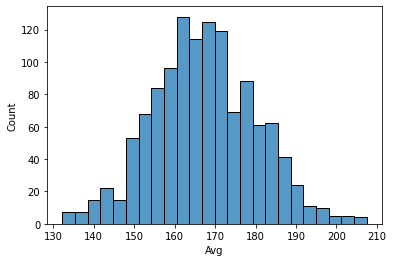

In [22]:
sns.histplot(data=df_prob2, x='Avg')
plt.show()

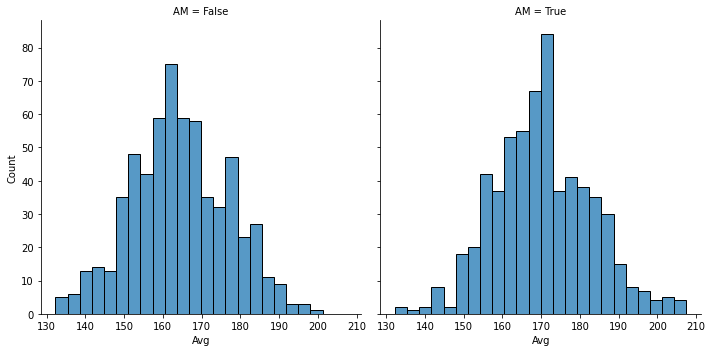

In [23]:
sns.displot(data=df_prob2, x='Avg', col='AM')

In [24]:
from scipy.stats import shapiro, bartlett
# (1)

res = shapiro(df_prob2.query('AM == 0')['Avg'])
A = res.pvalue
res, A

(ShapiroResult(statistic=0.9950335025787354, pvalue=0.043661389499902725),
 0.043661389499902725)

In [25]:
# (2)

res = shapiro(df_prob2.query('AM == 1')['Avg'])
B = res.pvalue
res, B

(ShapiroResult(statistic=0.9945228695869446, pvalue=0.026428762823343277),
 0.026428762823343277)

In [26]:
# (3)

bartlett(df_prob2.query('AM == 0')['Avg'], df_prob2.query('AM == 1')['Avg'])

BartlettResult(statistic=0.1500142357781029, pvalue=0.6985217544572233)

In [27]:
from scipy.stats import ttest_ind
ttest_ind(df_prob2.query('AM == 0')['Avg'], df_prob2.query('AM == 1')['Avg'], equal_var=True)

Ttest_indResult(statistic=-8.27772409322812, pvalue=3.2348808563995005e-16)

In [28]:
# (4)

D = 1 if A > 0.05 and B > 0.05 else 0
D

0

In [29]:
# (5)

from scipy.stats import mannwhitneyu
res = mannwhitneyu(df_prob2.query('AM == 0')['Avg'].values, df_prob2.query('AM == 1')['Avg'].values)
E = res.statistic
res, E

(MannwhitneyuResult(statistic=140292.5, pvalue=1.7651446950415233e-15),
 140292.5)

In [30]:
A + B + C + D + E

140303.57009015232

## 문제3

In [31]:
df_prob3 = df_basetable1.copy()
df_prob3.head()

15분  30분  45분  60분  DayName  Hour    AM  Weekend_yn  \
DateHour                                                                   
2021-01-01 00:00:00   62   61   61   61        4     0  True           0   
2021-01-01 01:00:00   96   93  116  113        4     1  True           0   
2021-01-01 02:00:00  106   96  106  107        4     2  True           0   
2021-01-01 03:00:00   92  110  110  109        4     3  True           0   
2021-01-01 04:00:00  108  105  106  108        4     4  True           0   

                     Holiday_yn     Avg  TotalHour  생산량   기온   풍속  습도  강수량  \
DateHour                                                                     
2021-01-01 00:00:00           1   61.25        245    0 -3.2  2.4  71  0.0   
2021-01-01 01:00:00           1  104.50        418    0 -4.5  1.5  77  0.0   
2021-01-01 02:00:00           1  103.75        415    0 -3.9  2.6  58  0.0   
2021-01-01 03:00:00           1  105.25        421    0 -4.1  2.6  56  0.0   
2021-01-01 04:00:00           1  106.75        427    0 -4.6  2.6  60  0.0   

                     전기요금(계절)  공장인원  인건비  
DateHour                                  
2021-01-01 00:00:00     109.8   0.0  1.5  
2021-01-01 01:00:00     109.8   0.0  1.5  
2021-01-01 02:00:00     109.8   0.0  1.5  
2021-01-01 03:00:00     109.8   0.0  1.5  
2021-01-01 04:00:00     109.8   0.0  1.5

In [32]:
df_prob3['target'] = df_prob3['TotalHour'].shift(-24)

In [33]:
df_prob3 = df_prob3.dropna()
df_prob3.head(5)

15분  30분  45분  60분  DayName  Hour    AM  Weekend_yn  \
DateHour                                                                   
2021-01-01 00:00:00   62   61   61   61        4     0  True           0   
2021-01-01 01:00:00   96   93  116  113        4     1  True           0   
2021-01-01 02:00:00  106   96  106  107        4     2  True           0   
2021-01-01 03:00:00   92  110  110  109        4     3  True           0   
2021-01-01 04:00:00  108  105  106  108        4     4  True           0   

                     Holiday_yn     Avg  TotalHour  생산량   기온   풍속  습도  강수량  \
DateHour                                                                     
2021-01-01 00:00:00           1   61.25        245    0 -3.2  2.4  71  0.0   
2021-01-01 01:00:00           1  104.50        418    0 -4.5  1.5  77  0.0   
2021-01-01 02:00:00           1  103.75        415    0 -3.9  2.6  58  0.0   
2021-01-01 03:00:00           1  105.25        421    0 -4.1  2.6  56  0.0   
2021-01-01 04:00:00           1  106.75        427    0 -4.6  2.6  60  0.0   

                     전기요금(계절)  공장인원  인건비  target  
DateHour                                          
2021-01-01 00:00:00     109.8   0.0  1.5   253.0  
2021-01-01 01:00:00     109.8   0.0  1.5   418.0  
2021-01-01 02:00:00     109.8   0.0  1.5   415.0  
2021-01-01 03:00:00     109.8   0.0  1.5   421.0  
2021-01-01 04:00:00     109.8   0.0  1.5   427.0

In [44]:
df_prob3_train = df_prob3.loc[df_prob3.index.date < pd.to_datetime('2021-08-14').date()]
df_prob3_test = df_prob3.loc[df_prob3.index.date >= pd.to_datetime('2021-08-14').date()]

In [45]:
df_prob3_train.shape, df_prob3_test.shape

((5400, 20), (744, 20))

In [46]:
X_cols_prob2 = ['15분', '30분', '45분', '60분', 
                'DayName', 'Hour', 'AM', 'Weekend_yn', 'Holiday_yn', 
                'Avg', 'TotalHour', '생산량', '기온', '풍속', '습도', '강수량', '전기요금(계절)', '공장인원', '인건비']
', '.join(X_cols_prob2)

'15분, 30분, 45분, 60분, DayName, Hour, AM, Weekend_yn, Holiday_yn, Avg, TotalHour, 생산량, 기온, 풍속, 습도, 강수량, 전기요금(계절), 공장인원, 인건비'

In [47]:
from sklearn.tree import DecisionTreeRegressor


reg_tree = DecisionTreeRegressor(min_samples_leaf=4, max_depth=10, random_state=123)
reg_tree.fit(df_prob3_train[X_cols_prob2], df_prob3_train['target'])

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, random_state=123)

In [48]:
reg_tree.feature_importances_, X_cols_prob2

(array([0.00568971, 0.01820437, 0.02433534, 0.03155363, 0.31249107,
        0.13836694, 0.0025863 , 0.011507  , 0.00552584, 0.18448738,
        0.00698797, 0.00246119, 0.12222486, 0.00835318, 0.04782553,
        0.01473692, 0.05613957, 0.00594418, 0.00057904]),
 ['15분',
  '30분',
  '45분',
  '60분',
  'DayName',
  'Hour',
  'AM',
  'Weekend_yn',
  'Holiday_yn',
  'Avg',
  'TotalHour',
  '생산량',
  '기온',
  '풍속',
  '습도',
  '강수량',
  '전기요금(계절)',
  '공장인원',
  '인건비'])

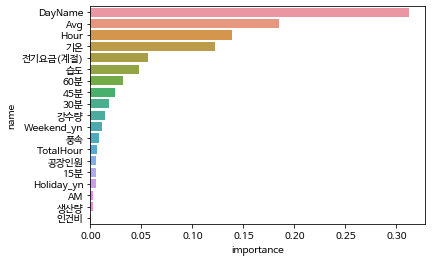

In [51]:
df_i = pd.DataFrame({'name': X_cols_prob2, 'importance': reg_tree.feature_importances_})\
                    .sort_values('importance', ascending=False)
sns.barplot(data=df_i, x='importance', y='name')
plt.show()

In [52]:
A = np.argmax(reg_tree.feature_importances_) + 1
X_cols_prob2[A - 1], A

('DayName', 5)

In [53]:
from sklearn.metrics import mean_absolute_error
B = mean_absolute_error(df_prob3_test['target'], reg_tree.predict(df_prob3_test[X_cols_prob2]))
B

37.27394388956255

In [54]:
from sklearn.ensemble import RandomForestRegressor
reg_tree = RandomForestRegressor(n_estimators=50, min_samples_leaf=4, max_depth=10, random_state=123)
reg_tree.fit(df_prob3_train[X_cols_prob2], df_prob3_train['target'])

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=50,
                      random_state=123)

In [55]:
C = mean_absolute_error(df_prob3_test['target'], reg_tree.predict(df_prob3_test[X_cols_prob2]))
C

33.827583781718324

In [56]:
A + B + C

76.10152767128088

# 문제 4

## 단계 4-1

In [57]:
concat_list = [df_prob3]
for i in range(1, 7):
    concat_list.append(df_prob3['TotalHour'].shift(i * 24).rename('lag_{}'.format(i)))

In [58]:
df_prob4 = pd.concat(concat_list, axis=1).dropna()

In [59]:
df_prob4.head(5)

15분  30분  45분  60분  DayName  Hour    AM  Weekend_yn  \
DateHour                                                                   
2021-01-07 00:00:00   22   22   22   25        3     0  True           0   
2021-01-07 01:00:00   26   22   22   22        3     1  True           0   
2021-01-07 02:00:00   22   21   21   22        3     2  True           0   
2021-01-07 03:00:00   22   22   22   23        3     3  True           0   
2021-01-07 04:00:00   22   26   26   23        3     4  True           0   

                     Holiday_yn    Avg  ...  전기요금(계절)      공장인원  인건비  target  \
DateHour                                ...                                    
2021-01-07 00:00:00           0  22.75  ...     109.8  0.000000  1.5   252.0   
2021-01-07 01:00:00           0  23.00  ...     109.8  0.369565  1.5   396.0   
2021-01-07 02:00:00           0  21.50  ...     109.8  0.000000  1.5   411.0   
2021-01-07 03:00:00           0  22.25  ...     109.8  0.629213  1.5   398.0   
2021-01-07 04:00:00           0  24.25  ...     109.8  2.865979  1.5   420.0   

                     lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  
DateHour                                                       
2021-01-07 00:00:00   96.0   96.0  271.0   88.0  253.0  245.0  
2021-01-07 01:00:00   85.0   85.0  432.0   99.0  418.0  418.0  
2021-01-07 02:00:00   85.0   85.0  439.0   88.0  415.0  415.0  
2021-01-07 03:00:00   90.0   90.0  426.0   88.0  421.0  421.0  
2021-01-07 04:00:00   93.0   93.0  435.0   95.0  427.0  427.0  

[5 rows x 26 columns]

## 단계 4-2

In [65]:
df_prob4_train = df_prob4.loc[df_prob4.index.date < pd.to_datetime('2021-08-14 00:00:00').date()].copy()
df_prob4_test = df_prob4.loc[df_prob4.index.date >= pd.to_datetime('2021-08-14 00:00:00').date()].copy()

In [66]:
df_prob4_train.shape, df_prob4_test.shape

((5256, 26), (744, 26))

## 단계 4-3 & 4

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [68]:
# 여러개의 방법을 보이기 위해 이전 데이터를 백업 해 둔다.
df_prob4_train_bak = df_prob4_train.copy()
df_prob4_test_bak = df_prob4_test.copy()

### 방법1

In [69]:
from sklearn.preprocessing import StandardScaler

lag_cols = ['lag_{}'.format(i) for i in range(1, 7)]
X_std_cols = ['TotalHour'] + lag_cols
X_cols_prob4 = X_std_cols
std_scaler = StandardScaler()
df_prob4_train[X_std_cols] = std_scaler.fit_transform(df_prob4_train[X_std_cols])
df_prob4_test[X_std_cols] = std_scaler.transform(df_prob4_test[X_std_cols])

In [70]:
# No. 1
reg_svm = SVR(kernel='linear', C=10)
reg_svm.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_svm.predict(df_prob4_test[X_cols_prob4]))

32.88361068048479

In [71]:
# No. 2
reg_svm = SVR(kernel='poly', degree=2, coef0=1, C=10, gamma=0.1)
reg_svm.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_svm.predict(df_prob4_test[X_cols_prob4]))

32.04119565841312

In [72]:
# No.3
reg_svm = SVR(kernel='rbf', C=10, gamma=0.1)
reg_svm.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_svm.predict(df_prob4_test[X_cols_prob4]))

30.01765885892802

In [73]:
A, B = 3, 30.017658858928023

### 방법2

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# No 1. 
df_prob4_train = df_prob4_train_bak.copy() # 원래 데이터로 원복
df_prob4_test =  df_prob4_test_bak.copy() # 원래 데이터로 원복

from sklearn.decomposition import PCA
ct_svm = ColumnTransformer([
    ('std', StandardScaler(), X_cols_prob4),
])

reg_svm = make_pipeline(ct_svm, SVR(kernel='linear', C=10))
reg_svm.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])

# No.2, No.3 은 생략

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['TotalHour', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6'])])),
                ('svr', SVR(C=10, kernel='linear'))])

In [75]:
mean_absolute_error(df_prob4_test['target'], reg_svm.predict(df_prob4_test[X_cols_prob4]))

32.88361068048479

## 단계 4-5

In [76]:
from sklearn.preprocessing import StandardScaler

lag_cols = ['lag_{}'.format(i) for i in range(1, 7)]
X_std_cols = ['TotalHour'] + lag_cols
X_cols_prob4 = X_std_cols
std_scaler = StandardScaler()
df_prob4_train[X_std_cols] = std_scaler.fit_transform(df_prob4_train[X_std_cols])
df_prob4_test[X_std_cols] = std_scaler.transform(df_prob4_test[X_std_cols])

In [77]:
from sklearn.neural_network import MLPRegressor
# No. 1
reg_nn = MLPRegressor([8], learning_rate_init=0.05,random_state=123, activation='relu', max_iter=500)
reg_nn.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_nn.predict(df_prob4_test[X_cols_prob4]))

39.68283671541336

In [78]:
# No. 2
reg_nn = MLPRegressor([8, 4], learning_rate_init=0.05,random_state=123, activation='relu', max_iter=500)
reg_nn.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_nn.predict(df_prob4_test[X_cols_prob4]))

38.57988917988749

In [79]:
# No. 3
reg_nn = MLPRegressor([8, 4], learning_rate_init=0.05,random_state=123, activation='logistic', max_iter=500)
reg_nn.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_nn.predict(df_prob4_test[X_cols_prob4]))

45.04498272523987

In [80]:
C, D = 2, 38.57988917988747

In [81]:
A + B + C + D

73.59754803881549

### vs DecisionTreeRegressor & RandomForestRegressor

In [83]:
# Decision Tree는 얼마나 효과가 있을 까?

reg_tree = DecisionTreeRegressor(min_samples_leaf=4, max_depth=10, random_state=123)
reg_tree.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_tree.predict(df_prob4_test[X_cols_prob4]))

41.78992997538093

In [84]:
from sklearn.decomposition import PCA

ct_2 = ColumnTransformer(
    [('pca', PCA(n_components=0.95), X_cols_prob4)],
    remainder='passthrough'
)
reg_rf = make_pipeline(ct_2, DecisionTreeRegressor(min_samples_leaf=4, max_depth=10, random_state=123))
reg_rf.fit(df_prob4_train[X_cols_prob2 + lag_cols], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_rf.predict(df_prob4_test[X_cols_prob2 + lag_cols]))

47.885837330326645

In [85]:
# Decision Tree는 얼마나 효과가 있을 까?

reg_rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=4, max_depth=10, random_state=123)
reg_rf.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_rf.predict(df_prob4_test[X_cols_prob4]))

39.94189837297465

In [86]:
from sklearn.decomposition import PCA

ct_2 = ColumnTransformer(
    [('pca', PCA(n_components=0.95), X_cols_prob4)],
    remainder='passthrough'
)
reg_rf = make_pipeline(ct_2, RandomForestRegressor(n_estimators=100, min_samples_leaf=4, max_depth=10, random_state=123))
reg_rf.fit(df_prob4_train[X_cols_prob2 + lag_cols], df_prob4_train['target'])
mean_absolute_error(df_prob4_test['target'], reg_rf.predict(df_prob4_test[X_cols_prob2 + lag_cols]))

36.54691171915926

# 문제5

In [82]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [83]:
X_prob5 = ['기온', '풍속', '습도', '강수량']
df_weather1 = df_info1[X_prob5].copy()

In [84]:
std_scaler = StandardScaler()
df_weather1[X_prob5] =  std_scaler.fit_transform(df_weather1[X_prob5])

In [85]:
dbscan = DBSCAN(eps=0.5, min_samples=7, algorithm='brute')

In [86]:
dbscan.fit(df_weather1[X_prob5])

DBSCAN(algorithm='brute', min_samples=7)

In [87]:
pd.Series(dbscan.labels_).value_counts()

 0    5899
-1     210
 2      12
 6       9
 3       7
 7       7
 8       7
 1       6
 4       6
 5       5
dtype: int64

In [88]:
from sklearn.ensemble import IsolationForest

In [93]:
IsolationForest?

In [94]:
#isof = IsolationForest(n_estimators=30, random_state=123, contamination='auto', behaviour='auto')

isof = IsolationForest(n_estimators=30, random_state=123, 
                       contamination='auto') #, behaviour='auto')
isof.fit(df_weather1[X_prob5])

IsolationForest(n_estimators=30, random_state=123)

In [95]:
pd.Series(isof.predict(df_weather1[X_prob5])).value_counts()

 1    4957
-1    1211
dtype: int64

In [96]:
from sklearn.neighbors import LocalOutlierFactor

In [97]:
lof = LocalOutlierFactor(n_neighbors=10, contamination='auto')

In [98]:
pd.Series(lof.fit_predict(df_weather1[X_prob5])).value_counts()

 1    6085
-1      83
dtype: int64

In [99]:
df_ol = df_weather1.assign(
    ol_dbscan=dbscan.labels_ == -1, 
    ol_isof=lambda x: isof.predict(x[X_prob5]) == -1,
    ol_lof=lof.fit_predict(df_weather1[X_prob5]) == -1
)

In [100]:
df_ol[['ol_dbscan', 'ol_isof', 'ol_lof']].sum(axis=0)

ol_dbscan     210
ol_isof      1211
ol_lof         83
dtype: int64

In [101]:
df_ol.loc[df_ol[['ol_dbscan', 'ol_isof', 'ol_lof']].all(axis=1)]

기온        풍속        습도       강수량  ol_dbscan  ol_isof  ol_lof
149  -2.380675  2.006965  0.648042 -0.212640       True     True    True
170  -3.046642 -0.483098 -1.569899 -0.233447       True     True    True
1437 -1.179751  1.062459  1.213399  4.406598       True     True    True
1438 -1.223421  0.547273  1.213399  5.051627       True     True    True
1460 -1.419936 -0.311369  0.387107  0.432389       True     True    True
1462 -1.529111 -0.225505  0.604553  0.432389       True     True    True
1463 -1.627368 -0.740690  0.778509  0.432389       True     True    True
1792  0.556130  1.148323 -2.700614 -0.181429       True     True    True
2374 -0.874061  0.032088 -0.178250  0.297141       True     True    True
3733  1.342189  2.522151 -1.482921 -0.233447       True     True    True
4436  1.036500 -1.771061  0.474086  2.336264       True     True    True
5125  1.527787 -1.255876  0.691531  1.503969       True     True    True
5133  1.200262 -1.341740  0.604553  1.503969       True     True    True
5135  1.058335 -1.599333  0.821998  1.503969       True     True    True
5640  0.861820  3.123200  1.213399  4.271350       True     True    True
5649  0.938242 -1.771061  1.213399  9.702076       True     True    True

In [102]:
A = df_ol['ol_dbscan'].sum()
B = df_ol['ol_isof'].sum()
C = df_ol['ol_lof'].sum()
D = np.sum(df_ol[['ol_dbscan', 'ol_isof', 'ol_lof']].all(axis=1))

A, B, C, D

(210, 1211, 83, 16)

In [103]:
A + B + C + D

1520

# 문제 6

In [104]:
df_prob4

15분  30분  45분  60분  DayName  Hour     AM  Weekend_yn  \
DateHour                                                                    
2021-01-07 00:00:00   22   22   22   25        3     0   True           0   
2021-01-07 01:00:00   26   22   22   22        3     1   True           0   
2021-01-07 02:00:00   22   21   21   22        3     2   True           0   
2021-01-07 03:00:00   22   22   22   23        3     3   True           0   
2021-01-07 04:00:00   22   26   26   23        3     4   True           0   
...                  ...  ...  ...  ...      ...   ...    ...         ...   
2021-09-13 19:00:00  162  160  148  122        0    19  False           0   
2021-09-13 20:00:00  113  122  122  126        0    20  False           0   
2021-09-13 21:00:00  122  131  122  115        0    21  False           0   
2021-09-13 22:00:00   97  108  122  113        0    22  False           0   
2021-09-13 23:00:00  111  123  110   87        0    23  False           0   

                     Holiday_yn     Avg  ...  전기요금(계절)      공장인원  인건비  target  \
DateHour                                 ...                                    
2021-01-07 00:00:00           0   22.75  ...     109.8  0.000000  1.5   252.0   
2021-01-07 01:00:00           0   23.00  ...     109.8  0.369565  1.5   396.0   
2021-01-07 02:00:00           0   21.50  ...     109.8  0.000000  1.5   411.0   
2021-01-07 03:00:00           0   22.25  ...     109.8  0.629213  1.5   398.0   
2021-01-07 04:00:00           0   24.25  ...     109.8  2.865979  1.5   420.0   
...                         ...     ...  ...       ...       ...  ...     ...   
2021-09-13 19:00:00           0  148.00  ...     167.2  4.763514  1.5   613.0   
2021-09-13 20:00:00           0  120.75  ...     167.2  0.028986  1.5   512.0   
2021-09-13 21:00:00           0  122.50  ...     167.2  0.146939  1.5   513.0   
2021-09-13 22:00:00           0  110.00  ...     167.2  0.025000  1.5   443.0   
2021-09-13 23:00:00           0  107.75  ...     167.2  0.800464  1.5   439.0   

                     lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  
DateHour                                                       
2021-01-07 00:00:00   96.0   96.0  271.0   88.0  253.0  245.0  
2021-01-07 01:00:00   85.0   85.0  432.0   99.0  418.0  418.0  
2021-01-07 02:00:00   85.0   85.0  439.0   88.0  415.0  415.0  
2021-01-07 03:00:00   90.0   90.0  426.0   88.0  421.0  421.0  
2021-01-07 04:00:00   93.0   93.0  435.0   95.0  427.0  427.0  
...                    ...    ...    ...    ...    ...    ...  
2021-09-13 19:00:00   92.0  101.0  567.0  569.0  601.0  609.0  
2021-09-13 20:00:00   93.0   93.0  464.0  513.0  413.0  535.0  
2021-09-13 21:00:00  100.0   93.0  466.0  510.0  487.0  524.0  
2021-09-13 22:00:00   92.0   93.0  409.0  437.0  422.0  461.0  
2021-09-13 23:00:00   91.0   91.0  351.0  436.0  403.0  443.0  

[6000 rows x 26 columns]

In [105]:
df_prob6_train = df_prob4.loc[df_prob4.index.date < pd.to_datetime('2021-08-14 00:00:00').date()].copy()
df_prob6_test = df_prob4.loc[df_prob4.index.date >= pd.to_datetime('2021-08-14 00:00:00').date()].copy()

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

lag_cols = ['lag_{}'.format(i) for i in range(1, 7)]

## 1st model: SVR

In [107]:
from sklearn.svm import SVR

X_cols_svr = ['TotalHour'] + lag_cols
ct_svm = ColumnTransformer(
    [('std', StandardScaler(), X_cols_svr)]
)
reg_svr = make_pipeline(ct_svm, SVR(kernel='rbf', gamma=0.1, C=10))
reg_svr.fit(df_prob6_train[X_cols_svr], df_prob6_train['target'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['TotalHour', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6'])])),
                ('svr', SVR(C=10, gamma=0.1))])

In [108]:
mean_absolute_error(df_prob6_test['target'], reg_svr.predict(df_prob6_test[X_cols_svr]))

30.01765885892802

## 2nd model: MLP

In [109]:
from sklearn.neural_network import MLPRegressor

X_cols_nn = ['TotalHour'] + lag_cols
ct_nn =ColumnTransformer(
    [('std', StandardScaler(), X_cols_nn)]
)
reg_nn =make_pipeline(ct_nn, MLPRegressor([8, 4], activation='relu', learning_rate_init=0.05, random_state=123))
reg_nn.fit(df_prob6_train[X_cols_nn], df_prob6_train['target'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['TotalHour', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6'])])),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[8, 4],
                              learning_rate_init=0.05, random_state=123))])

In [110]:
mean_absolute_error(df_prob6_test['target'], reg_nn.predict(df_prob6_test[X_cols_nn]))

38.57988917988749

In [111]:
mean_absolute_error(df_prob6_test['target'], 
                    reg_svr.predict(df_prob6_test[X_cols_svr]) * 0.5 + reg_nn.predict(df_prob6_test[X_cols_nn]) * 0.5)

30.65038683490609

## 3rd model: DecisionTree

In [112]:
from sklearn.tree import DecisionTreeRegressor

X_cols_tree = ['15분', '30분', '45분', '60분', 
                'DayName', 'Hour', 'AM', 'Weekend_yn', 'Holiday_yn', 
                'Avg', 'TotalHour', '생산량', '기온', '풍속', '습도', '강수량', '전기요금(계절)', '공장인원', '인건비']

reg_tree = DecisionTreeRegressor(min_samples_leaf=4, max_depth=10, random_state=123)
reg_tree.fit(df_prob6_train[X_cols_tree], df_prob6_train['target'])

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, random_state=123)

In [113]:
mean_absolute_error(df_prob6_test['target'], reg_tree.predict(df_prob6_test[X_cols_tree]))

43.965996579335304

In [114]:
mean_absolute_error(df_prob6_test['target'], 
                    reg_svr.predict(df_prob6_test[X_cols_svr]) * 0.33 + \
                    reg_nn.predict(df_prob6_test[X_cols_nn]) * 0.33 + \
                    reg_tree.predict(df_prob6_test[X_cols_tree]) * 0.33)

32.2280606312642

In [115]:
from sklearn.ensemble import RandomForestRegressor

X_cols_rf = ['15분', '30분', '45분', '60분', 
                'DayName', 'Hour', 'AM', 'Weekend_yn', 'Holiday_yn', 
                'Avg', 'TotalHour', '생산량', '기온', '풍속', '습도', '강수량', '전기요금(계절)', '공장인원', '인건비']

reg_rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=4, max_depth=10, random_state=123)
reg_rf.fit(df_prob6_train[X_cols_rf], df_prob6_train['target'])

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=123)

In [116]:
mean_absolute_error(df_prob6_test['target'], reg_rf.predict(df_prob6_test[X_cols_tree]))

32.67221491876342

In [117]:
mean_absolute_error(df_prob6_test['target'], 
                    reg_svr.predict(df_prob6_test[X_cols_svr]) * 0.33 + \
                    reg_nn.predict(df_prob6_test[X_cols_nn]) * 0.33 + \
                    reg_rf.predict(df_prob6_test[X_cols_rf]) * 0.33)

29.252095508554362

In [118]:
mean_absolute_error(df_prob6_test['target'], 
                    reg_svr.predict(df_prob6_test[X_cols_svr]) * 0.5 + \
                    reg_rf.predict(df_prob6_test[X_cols_rf]) * 0.5)

27.619942632661814

In [119]:
from scipy.stats import spearmanr

spearmanr(reg_svr.predict(df_prob6_test[X_cols_svr]), reg_nn.predict(df_prob6_test[X_cols_nn]))

SpearmanrResult(correlation=0.979078340181304, pvalue=0.0)

In [120]:
spearmanr(reg_svr.predict(df_prob6_test[X_cols_svr]), reg_rf.predict(df_prob6_test[X_cols_rf]))

SpearmanrResult(correlation=0.9412921690893483, pvalue=0.0)

In [121]:
spearmanr(reg_nn.predict(df_prob6_test[X_cols_nn]), reg_rf.predict(df_prob6_test[X_cols_rf]))

SpearmanrResult(correlation=0.9416020833487827, pvalue=0.0)

In [122]:
# answer6.csv 파일 생성
df_ans = pd.DataFrame({'TotalHour': reg_svr.predict(df_prob6_test[X_cols_svr]) * 0.5 + \
                          reg_rf.predict(df_prob6_test[X_cols_rf]) * 0.5}, index=df_prob6_test.index)
df_ans    

TotalHour
DateHour                       
2021-08-14 00:00:00  102.607580
2021-08-14 01:00:00   94.078890
2021-08-14 02:00:00   92.688439
2021-08-14 03:00:00   90.273844
2021-08-14 04:00:00   86.053049
...                         ...
2021-09-13 19:00:00  614.975988
2021-09-13 20:00:00  503.570559
2021-09-13 21:00:00  505.931288
2021-09-13 22:00:00  455.807737
2021-09-13 23:00:00  438.601437

[744 rows x 1 columns]

In [123]:
df_ans.to_csv('answer6.csv')

In [124]:
# 만일 아래와 같이 DataHour를 Index로 하지 않고 Column으로 뺐다면, 
df_ans.reset_index()

DateHour   TotalHour
0   2021-08-14 00:00:00  102.607580
1   2021-08-14 01:00:00   94.078890
2   2021-08-14 02:00:00   92.688439
3   2021-08-14 03:00:00   90.273844
4   2021-08-14 04:00:00   86.053049
..                  ...         ...
739 2021-09-13 19:00:00  614.975988
740 2021-09-13 20:00:00  503.570559
741 2021-09-13 21:00:00  505.931288
742 2021-09-13 22:00:00  455.807737
743 2021-09-13 23:00:00  438.601437

[744 rows x 2 columns]

In [129]:
# index = False로 줘야 한다.
df_ans.reset_index().to_csv('answer6.csv')

In [130]:
!head answer6.csv

,DateHour,TotalHour
0,2021-08-14 00:00:00,102.60758021878459
1,2021-08-14 01:00:00,94.07888980063362
2,2021-08-14 02:00:00,92.68843907302228
3,2021-08-14 03:00:00,90.2738443881681
4,2021-08-14 04:00:00,86.05304853595176
5,2021-08-14 05:00:00,95.92916244162382
6,2021-08-14 06:00:00,79.18753027050136
7,2021-08-14 07:00:00,68.69901354200596
8,2021-08-14 08:00:00,106.43579979289417


In [131]:
# index = False로 줘야 한다.
df_ans.reset_index().to_csv('answer6.csv', index=False)

In [132]:
!head answer6.csv

DateHour,TotalHour
2021-08-14 00:00:00,102.60758021878459
2021-08-14 01:00:00,94.07888980063362
2021-08-14 02:00:00,92.68843907302228
2021-08-14 03:00:00,90.2738443881681
2021-08-14 04:00:00,86.05304853595176
2021-08-14 05:00:00,95.92916244162382
2021-08-14 06:00:00,79.18753027050136
2021-08-14 07:00:00,68.69901354200596
2021-08-14 08:00:00,106.43579979289417
